Problem: Solve the 2D Poisson equation with Dirichlet boundary conditions.

Domain: Consider a bounded domain $\Omega$ in 2D, defined as $\Omega = [a, b] \times [c, d]$, where a, b, c, and d are the bounds of the domain.

The Poisson equation is given by:

$$ \Delta u(x,y) = f(x,y) \text{ for } (x,y) \in \Omega$$

Boundary Conditions: The Dirichlet boundary conditions specify the values of the solution $u(x, y)$ on the boundary $\partial \Omega$:
$$ u(x,y) = g(x,y) \text{ for } (x,y) \in \partial\Omega $$

In this case we take:
$$ f(x,y) = -\sin{(\pi x)} \sin{(\pi y)}$$
$$ g(x,y) = 0 $$
$$ \Omega = [0, 1] \times [0, 1] $$


In [88]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

# Define the domain
a, b = 0.0, 1.0
c, d = 0.0, 1.0

# Define the right-hand side function
def fun_f(x, y):
    return -tf.sin(pi * x) * tf.sin(pi * y)

# Define the boundary condition function
def fun_g(x, y):
    return tf.zeros_like(x)


In [89]:
# Set number of data points
N_r = 10000
N_bc = 200
# Set random seed for reproducible results
tf.random.set_seed(0)
# Generate random points in the domain
x_r = tf.random.uniform((N_r, 1), a, b, dtype=DTYPE)
y_r = tf.random.uniform((N_r, 1), c, d, dtype=DTYPE)
X_r = tf.concat([x_r, y_r], axis=1)

# Compute the right-hand side values at the random points
f = fun_f(x_r, y_r)

num_bounds = N_bc // 4
# Generate random points along the border of the domain
x_bc_top = tf.random.uniform((num_bounds, 1), a, b, dtype=DTYPE)
x_bc_bottom = tf.random.uniform((num_bounds, 1), a, b, dtype=DTYPE)
y_bc_left = tf.random.uniform((num_bounds, 1), c, d, dtype=DTYPE)
y_bc_right = tf.random.uniform((num_bounds, 1), c, d, dtype=DTYPE)
X_b = tf.concat([tf.concat([x_bc_top, tf.fill((num_bounds, 1), b)], axis=1),
                 tf.concat([x_bc_bottom, tf.fill((num_bounds, 1), a)], axis=1),
                 tf.concat([tf.fill((num_bounds, 1), c), y_bc_left], axis=1),
                 tf.concat([tf.fill((num_bounds, 1), d), y_bc_right], axis=1)
                ], axis=0)

# Compute the boundary condition values at the boundary points
g_data = fun_g(X_b[:, 0], X_b[:, 1])

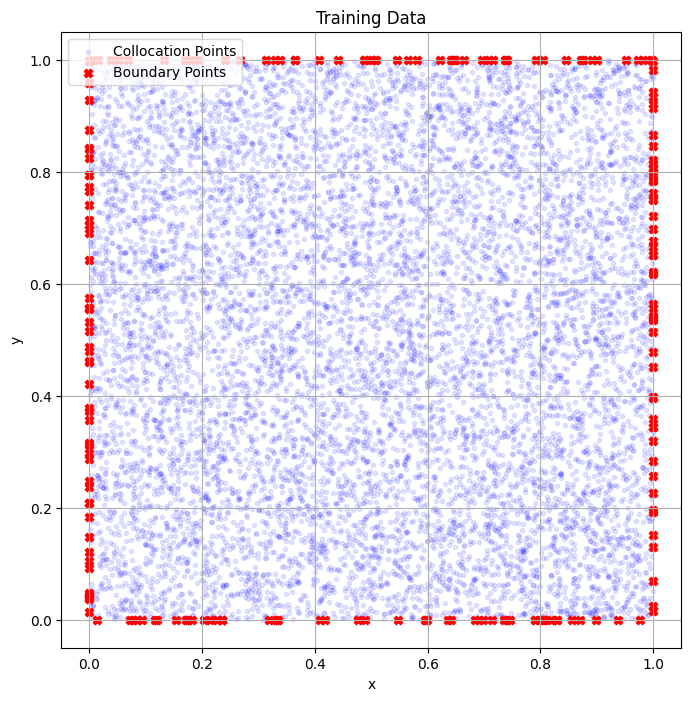

In [90]:
# Plotting the training data
plt.figure(figsize=(8, 8))
plt.scatter(x_r, y_r, color='blue', marker='.', alpha=0.1, label='Collocation Points')
plt.scatter(X_b[:, 0], X_b[:, 1], color='red', marker='X', label='Boundary Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Data')
plt.grid(True)
plt.legend()
plt.show()

In [91]:
def init_model(num_hidden_layers=5, num_neurons_per_layer=15):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (x,y spatial dimension)
    model.add(tf.keras.Input(2, name="Input_Layer"))

    # Append hidden layers
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal', name=f"Hidden_Layer_{i+1}"))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1, name="Output_Layer"))
    
    return model

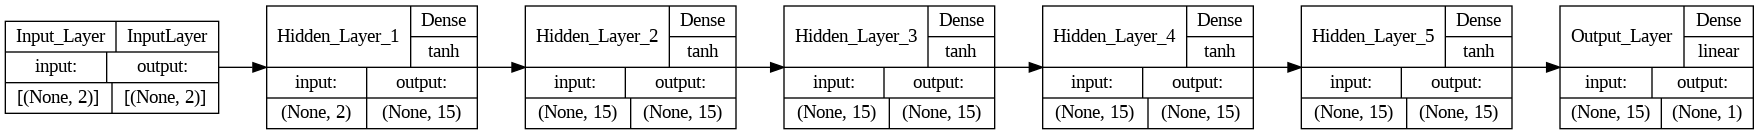

In [92]:
from tensorflow import keras
model = init_model()
keras.utils.plot_model(model, show_shapes=True, rankdir="LR", show_layer_activations=True)

In [93]:
def get_r(model, x, y):
  with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(y)
        u = model(tf.concat([x, y], axis=1))
        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)
        
  laplace_u = tape.gradient(u_x, x) + tape.gradient(u_y, y)
  residual = laplace_u - f
  del tape
  return residual

In [94]:
def compute_loss(model, X_r, X_b, g_data):
    # Compute phi^r
    x, y = X_r[:, 0:1], X_r[:,1:2]
    r = get_r(model, x, y)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^b to the loss
    u_pred = model(X_b)
    loss += tf.reduce_mean(tf.square(g_data - u_pred))
    return loss

In [95]:
def get_grad(model, X_r, X_b, g_data):
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_b, g_data)
    gradients = tape.gradient(loss, model.trainable_variables)
    del tape
    return loss, gradients

In [96]:
from time import time

# Define the optimizer
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)
model = init_model()

# Training loop
N_epochs = 5000
hist = []
t0 = time()
for i in range(N_epochs):
    loss, grad_theta = get_grad(model, X_r, X_b, g_data)
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    hist.append(loss.numpy())
    if (i + 1) % 100 == 0:
        print(f"Step {i+1}, Loss: {loss:.6f}")
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Step 100, Loss: 0.002312
Step 200, Loss: 0.001248
Step 300, Loss: 0.001607
Step 400, Loss: 0.000476
Step 500, Loss: 0.000127
Step 600, Loss: 0.000232
Step 700, Loss: 0.000061
Step 800, Loss: 0.000554
Step 900, Loss: 0.000047
Step 1000, Loss: 0.000033
Step 1100, Loss: 0.000032
Step 1200, Loss: 0.000032
Step 1300, Loss: 0.000031
Step 1400, Loss: 0.000030
Step 1500, Loss: 0.000030
Step 1600, Loss: 0.000029
Step 1700, Loss: 0.000028
Step 1800, Loss: 0.000028
Step 1900, Loss: 0.000027
Step 2000, Loss: 0.000027
Step 2100, Loss: 0.000026
Step 2200, Loss: 0.000025
Step 2300, Loss: 0.000025
Step 2400, Loss: 0.000024
Step 2500, Loss: 0.000023
Step 2600, Loss: 0.000023
Step 2700, Loss: 0.000022
Step 2800, Loss: 0.000022
Step 2900, Loss: 0.000021
Step 3000, Loss: 0.000020
Step 3100, Loss: 0.000020
Step 3200, Loss: 0.000020
Step 3300, Loss: 0.000019
Step 3400, Loss: 0.000019
Step 3500, Loss: 0.000019
Step 3600, Loss: 0.000018
Step 3700, Loss: 0.000018
Step 3800, Loss: 0.000018
Step 3900, Loss: 0.00

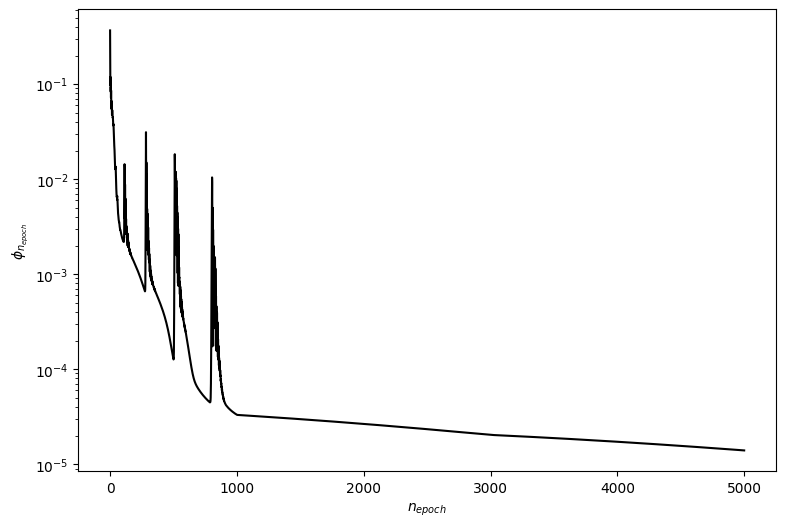

In [97]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

In [98]:
def analytical_sol(x,y):
  return tf.sin(pi * x) * tf.sin(pi * y) / (2*pi**2)

In [99]:
# Generate grid points in the domain for visualization
N = 1000
xspace = np.linspace(a, b, N + 1)
yspace = np.linspace(c, d, N + 1)
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(), Y.flatten()]).T

# Compute the solution at the grid points
u_pred = model(Xgrid)
upred = model(tf.cast(Xgrid,DTYPE))
U_pred = upred.numpy().reshape(N+1, N+1)

# Compute the analytical solution at the grid points
u_real = analytical_sol(Xgrid[:, 0], Xgrid[:, 1])
U_real = u_real.numpy().reshape(N+1, N+1)

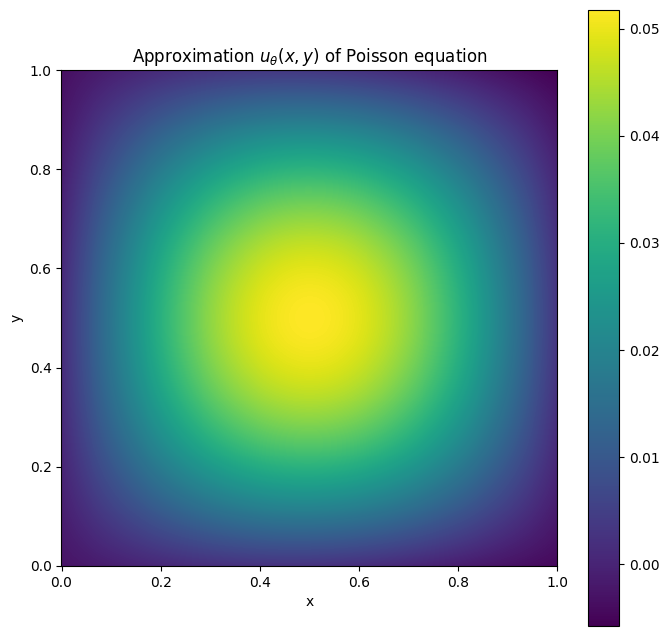

In [100]:
plt.figure(figsize=(8, 8))
plt.gca().set_aspect('equal') 
plt.pcolormesh(xspace, yspace, U_pred, shading='auto', cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Approximation $u_{\\theta}(x,y)$ of Poisson equation')
plt.savefig('pinn_poisson.png', dpi=600, bbox_inches='tight')

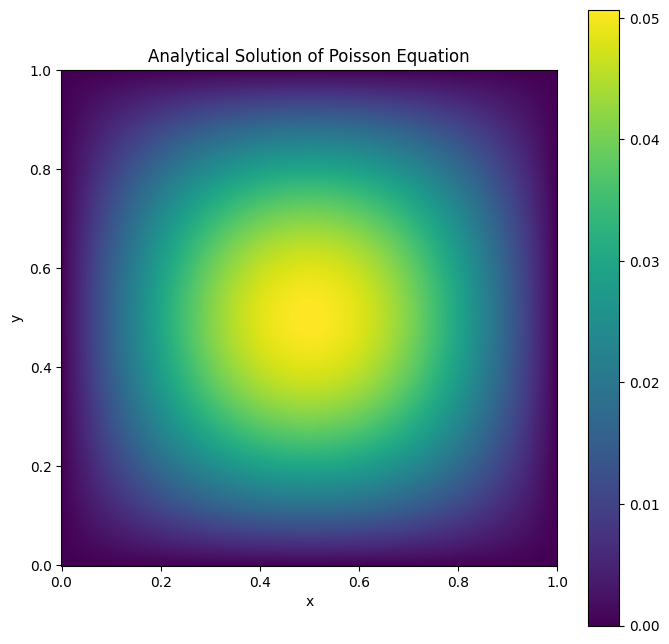

In [101]:
plt.figure(figsize=(8, 8))
plt.gca().set_aspect('equal') 
plt.pcolormesh(xspace, yspace, U_real, shading='auto', cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Analytical Solution of Poisson Equation')
plt.savefig('real_poisson.png', dpi=600, bbox_inches='tight')

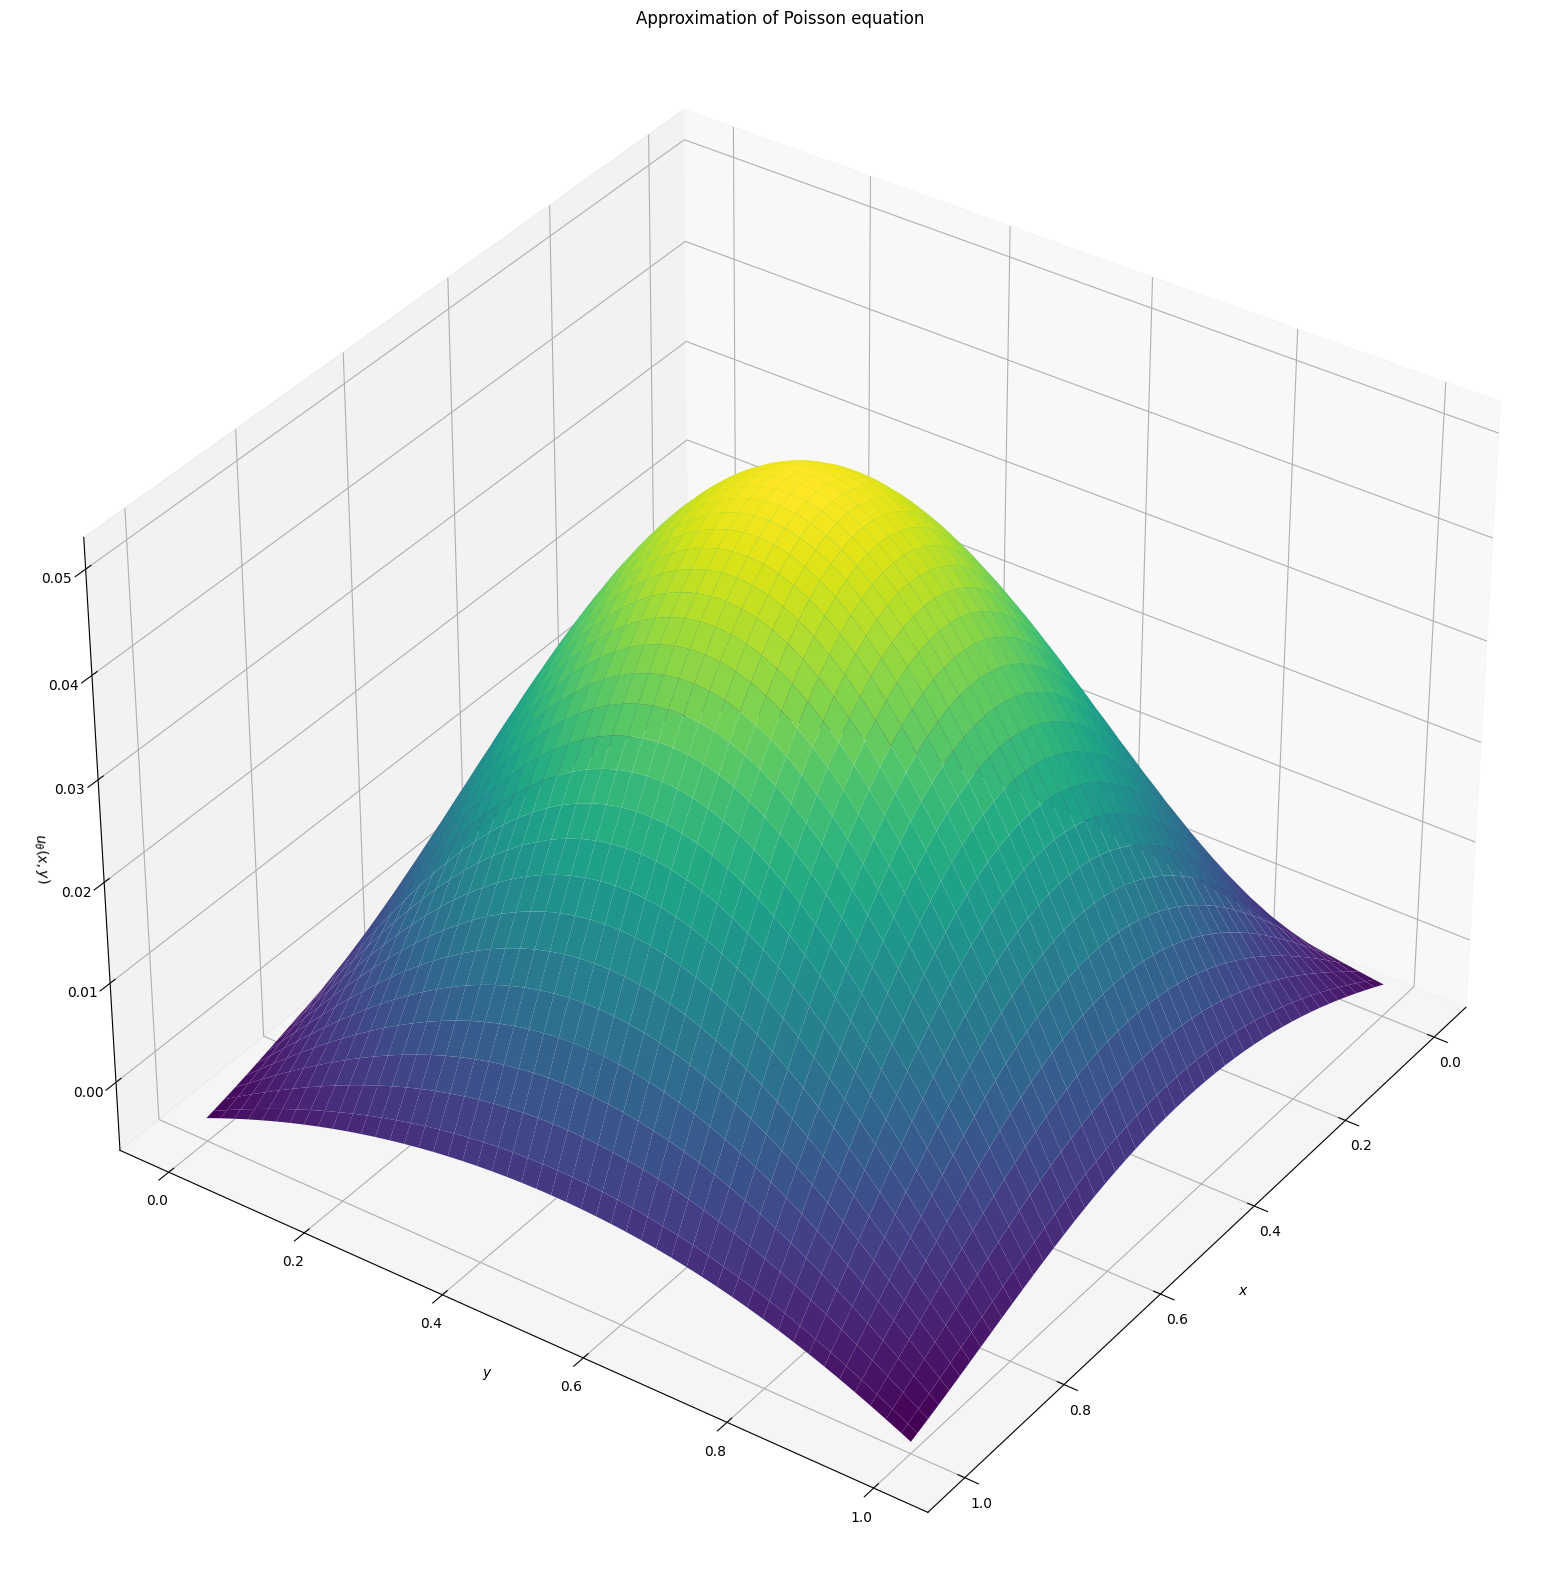

In [102]:
from mpl_toolkits.mplot3d import Axes3D
# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U_pred, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$u_\\theta(x,y)$')
ax.set_title('Approximation of Poisson equation');
plt.savefig('Poisson_Solution.png', bbox_inches='tight', dpi=600);

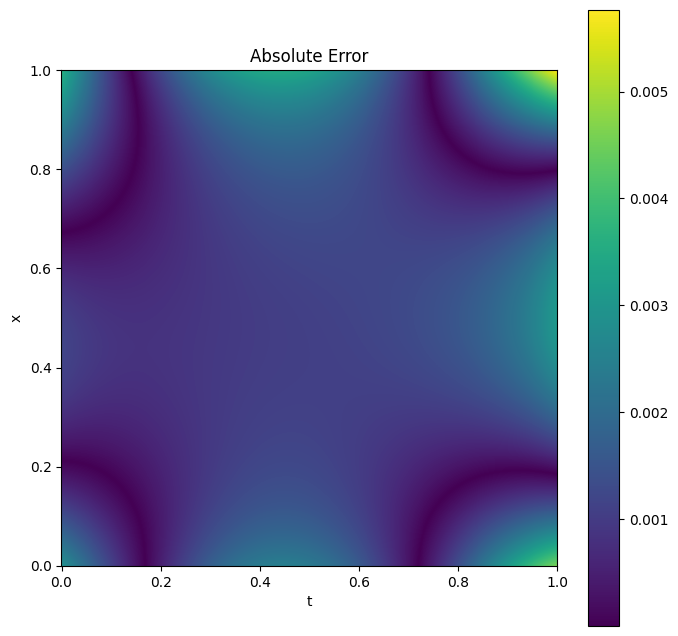

In [104]:
U_error = np.abs(U_real - U_pred)
plt.figure(figsize=(8, 8))
plt.gca().set_aspect('equal') 
plt.pcolormesh(xspace, yspace, U_error, shading='auto', cmap='viridis')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Absolute Error')
plt.savefig('poisson_comparison.png', dpi=600, bbox_inches='tight')